<a href="https://colab.research.google.com/github/TomohiroYazaki/Tabular_Playground_Series_-_Mar_2021/blob/main/Tabular_Playground_Series___Mar_2021_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install optuna

In [2]:
!pip install --upgrade scikit-learn

Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.7/dist-packages (0.24.1)


In [3]:
#!pip install --upgrade pandas

In [4]:
!pip install pytorch-tabnet

In [5]:
!pip install catboost

In [6]:
!pip install category_encoders

In [7]:
import numpy as np
import os
import random
import sys
import statistics
import pandas as pd
from pathlib import Path
import time
from datetime import datetime
import pytz
import json
from tqdm import tqdm

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))
        
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import LocalOutlierFactor
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from sklearn.calibration import calibration_curve
from sklearn.calibration import CalibratedClassifierCV

import xgboost as xgb
import lightgbm as lgb
import catboost as cb

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
from pytorch_tabnet.tab_model import TabNetRegressor

import optuna

import warnings
warnings.filterwarnings("ignore")
        
#input_path = Path('/kaggle/input/tabular-playground-series-jan-2021/')
input_path = Path('/content/drive/MyDrive/Kaggle/Tabular_Playground_Series_-_Mar_2021/Data')

**---------- Utilities ----------**

In [8]:
!rm -f /content/log.log
!rm -f /content/result.png
!rm -f /content/submission.csv
!rm -f /content/plot_optimization_history.html
!rm -f /content/plot_parallel_coordinate.html
!rm -f /content/plot_slice.html
!rm -f /content/plot_param_importances.html
!rm -f /content/plot_contour.html
!rm -f /content/best_params.json

In [9]:
def get_logger(filename='log'):
    from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    #handler1 = StreamHandler()
    #handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    #logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

logger = get_logger('log')

In [10]:
import logging

from lightgbm.callback import _format_eval_result


def log_evaluation(logger, period=1, show_stdv=True, level=logging.DEBUG):
    def _callback(env):
        if period > 0 and env.evaluation_result_list and (env.iteration + 1) % period == 0:
            result = '\t'.join([_format_eval_result(x, show_stdv) for x in env.evaluation_result_list])
            logger.info('[{}]\t{}'.format(env.iteration+1, result))
    _callback.order = 10
    return _callback

In [11]:
def convDictKeyToNdarray(dict):
    return np.array([list(dict.keys())])

In [12]:
def plot_results(name, target, pred, figsize=(6,6)):
    plt.figure(0).clf()

    fig = plt.figure(figsize=figsize)
    fpr, tpr, thresh = metrics.roc_curve(target, pred)
    auc = metrics.roc_auc_score(target, pred)
    plt.title(f'{name}: {auc:0.5f}', fontsize=18)
    plt.plot(fpr,tpr,label=name)
    plt.legend(loc=0)
    plt.show()
    fig.savefig("result.png")
    #return fig

In [13]:
def seed_everything(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        
seed_everything(21)

**---------- Data Processing ----------**

In [14]:
cont_features = [
    "cont0", "cont1", "cont2", "cont3", "cont4", "cont5", "cont6", "cont7",
    "cont8", "cont9", "cont10",
]
cat_features = [
    "cat0", "cat1", "cat2", "cat3", "cat4", "cat5", "cat6", "cat7",
    "cat8", "cat9", "cat10", "cat11", "cat12", "cat13", "cat14", "cat15",
    "cat16", "cat17", "cat18"
]

In [15]:
def replace_outliers(data):
    for col in cont_features:
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        median_ = data[col].median()
#         data[col].mask(((data[col] < Q1 - 1.5*IQR) | (data[col] > Q3 + 1.5*IQR)), median_, inplace=True)
        # data[col] = np.where(((data[col] < Q1 - 1.5*IQR) | (data[col] > Q3 + 1.5*IQR)),
        #                     median_, data[col])
        #data.loc[((data[col] < Q1 - 1.5*IQR) | (data[col] > Q3 + 1.5*IQR)), col] = median_
        data.loc[((data[col] < Q1 - 1.5*IQR)), col] = Q1 - 1.5*IQR
        data.loc[((data[col] > Q3 + 1.5*IQR)), col] = Q3 + 1.5*IQR
        logger.info(f'replace_outliers : Q1 - 1.5*IQR,Q3 + 1.5*IQR')
    return data

In [16]:
def label_encode(train, test):
    for column in train.columns:
        if 'cat' in column:
            le = preprocessing.LabelEncoder()
            le.fit(list(train[column].astype('str')) + list(test[column].astype('str')))
            train[column] = le.transform(list(train[column].astype(str))) 
            test[column] = le.transform(list(test[column].astype(str))) 
    return train, test

In [17]:
def reject_outliers(df, feature, threshold=3):
    mean, std = np.mean(df), np.std(df)
    z_score = np.abs((df-mean) / std)
    good = z_score < threshold
    return good

In [18]:
def reject_lof_outliers(df, feature):
    lof = LocalOutlierFactor(n_neighbors=20, contamination=0.001, p=1)
    good = lof.fit_predict(df) > 0.5 # change this value to set the threshold for outliers    
    return good

In [19]:
def apply_pca(train, test, n_components=5):
    pca_columns = ['pca' + str(i) for i in range(n_components)]
    pca = PCA(n_components=n_components)
    pca.fit(train[cont_features])
    for i, c in enumerate(pca_columns):
        train[c] = pca.transform(train[cont_features])[:,i]
        test[c] = pca.transform(test[cont_features])[:,i]
    #train.drop(columns=cont_features, inplace=True)
    #test.drop(columns=cont_features, inplace=True)
    return train, test

In [20]:
def add_features_times(train, test):
    logger.info(f'add_features_times')
    for i in range(len(cont_features)):
        for j in range(i+1,len(cont_features)):
            feature_name = cont_features[i] + '*' + cont_features[j]
            train[feature_name] = train[cont_features[i]] * train[cont_features[j]]
            test[feature_name] = test[cont_features[i]] * test[cont_features[j]]
    return train, test

In [21]:
def add_features_division(train, test):
    logger.info(f'add_features_division')
    for i in cont_features:
        for j in cont_features:
            if i != j:
                feature_name = i + '/' + j
                train[feature_name] = train[i] / train[j]
                test[feature_name] = test[i] / test[j]
    return train, test

In [22]:
def add_features_statistics(train, test):
    logger.info(f'add_features_statistics')
    for i in cat_features:
        for j in cont_features:
            feature_name_count = i + '_' + j + '_count'
            feature_name_mean = i + '_' + j + '_mean'
            feature_name_std = i + '_' + j + '_std'
            feature_name_min = i + '_' + j + '_min'
            feature_name_max = i + '_' + j + '_max'
            feature_name_median = i + '_' + j + '_median'

            train[feature_name_count] = train[i]
            train[feature_name_mean] = train[i] 
            train[feature_name_std] = train[i] 
            train[feature_name_min] = train[i] 
            train[feature_name_max] = train[i] 
            train[feature_name_median] = train[i] 

            test[feature_name_count] = test[j]
            test[feature_name_mean] = test[j]
            test[feature_name_std] = test[j]
            test[feature_name_min] = test[j]
            test[feature_name_max] = test[j]
            test[feature_name_median] = test[j]

            for k, s in enumerate(train.groupby(i)[j].count()):
                train[feature_name_count].loc[train[feature_name_count] == k] = s
                test[feature_name_count].loc[test[feature_name_count] == k] = s

            for k, s in enumerate(train.groupby(i)[j].mean()):
                train[feature_name_mean].loc[train[feature_name_mean] == k] = s
                test[feature_name_mean].loc[test[feature_name_mean] == k] = s

            for k, s in enumerate(train.groupby(i)[j].std()):
                train[feature_name_std].loc[train[feature_name_std] == k] = s
                test[feature_name_std].loc[test[feature_name_std] == k] = s

            for k, s in enumerate(train.groupby(i)[j].min()):
                train[feature_name_min].loc[train[feature_name_min] == k] = s
                test[feature_name_min].loc[test[feature_name_min] == k] = s

            for k, s in enumerate(train.groupby(i)[j].max()):
                train[feature_name_max].loc[train[feature_name_max] == k] = s
                test[feature_name_max].loc[test[feature_name_max] == k] = s
            
            for k, s in enumerate(train.groupby(i)[j].median()):
                train[feature_name_median].loc[train[feature_name_median] == k] = s
                test[feature_name_median].loc[test[feature_name_median] == k] = s
  

    return train, test

In [23]:
train = pd.read_csv(input_path / 'train.csv', index_col='id')
#train = pd.read_csv(input_path / 'train4.csv', index_col='id')
display(train.head())

,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,cat11,cat12,cat13,cat14,cat15,cat16,cat17,cat18,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,target
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,A,I,A,B,B,BI,A,S,Q,A,LO,A,A,A,A,B,D,D,B,0.629858,0.855349,0.759439,0.795549,0.681917,0.621672,0.592184,0.791921,0.815254,0.965006,0.665915,0
1,A,I,A,A,E,BI,K,W,AD,F,HJ,A,B,A,B,D,B,D,B,0.370727,0.328929,0.386385,0.541366,0.388982,0.357778,0.600044,0.408701,0.399353,0.927406,0.493729,0
2,A,K,A,A,E,BI,A,E,BM,L,DJ,A,B,A,A,B,D,D,B,0.502272,0.322749,0.343255,0.616352,0.793687,0.552877,0.352113,0.388835,0.412303,0.292696,0.549452,0
3,A,K,A,C,E,BI,A,Y,AD,F,KV,A,A,A,A,B,D,D,B,0.934242,0.707663,0.831147,0.807807,0.800032,0.619147,0.221789,0.897617,0.633669,0.760318,0.934242,0
4,A,I,G,B,E,BI,C,G,Q,A,DP,A,A,A,B,B,B,D,B,0.254427,0.274514,0.338818,0.277308,0.610578,0.128291,0.578764,0.279167,0.351103,0.357084,0.328960,1


In [24]:
test = pd.read_csv(input_path / 'test.csv', index_col='id')
#test = pd.read_csv(input_path / 'test4.csv', index_col='id')
display(test.head())

,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,cat11,cat12,cat13,cat14,cat15,cat16,cat17,cat18,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5,A,F,A,A,F,BI,A,AH,AX,A,LF,A,A,A,A,B,D,D,B,0.708120,0.735690,0.578366,0.723154,0.228037,0.356227,0.551249,0.655693,0.598331,0.359987,0.947489
6,A,H,C,A,E,AB,I,F,N,A,MC,A,A,A,B,D,B,D,B,0.611637,0.313703,0.928885,0.516602,0.600169,0.795224,0.248987,0.654614,0.347944,0.565520,0.388580
8,A,N,C,A,F,AB,A,AH,BC,A,FN,A,A,A,B,B,D,D,B,0.456289,0.448201,0.424876,0.344729,0.242073,0.270632,0.746740,0.335590,0.341238,0.252289,0.411592
9,B,L,C,A,F,BI,A,E,AX,A,HK,A,A,A,A,B,D,B,B,0.338692,0.666092,0.598943,0.561971,0.806347,0.735983,0.538724,0.381566,0.481660,0.348514,0.325723
11,A,F,A,B,F,BI,A,AH,I,A,HX,A,A,A,A,D,D,D,B,0.631671,0.772229,0.479572,0.767745,0.252454,0.354810,0.178920,0.763479,0.562491,0.466261,0.585781


In [25]:
'''
from category_encoders import LeaveOneOutEncoder
from sklearn.preprocessing import LabelEncoder

xgb_cat_features = []
lgb_cat_features = []
cb_cat_features = []
ridge_cat_features = []
sgd_cat_features = []

loo_features = []
le_features = []

def label_encode(train_df, test_df, column):
    le = LabelEncoder()
    new_feature = "{}_le".format(column)
    le.fit(train_df[column].unique().tolist() + test_df[column].unique().tolist())
    train_df[new_feature] = le.transform(train_df[column])
    test_df[new_feature] = le.transform(test_df[column])
    return new_feature

def loo_encode(train_df, test_df, column):
    loo = LeaveOneOutEncoder()
    new_feature = "{}_loo".format(column)
    loo.fit(train_df[column], train_df["target"])
    train_df[new_feature] = loo.transform(train_df[column])
    test_df[new_feature] = loo.transform(test_df[column])
    return new_feature

for feature in cat_features:
    loo_features.append(loo_encode(train, test, feature))
    le_features.append(label_encode(train, test, feature))
    
xgb_cat_features.extend(loo_features)
lgb_cat_features.extend(le_features)
cb_cat_features.extend(cat_features)
ridge_cat_features.extend(loo_features)
sgd_cat_features.extend(loo_features)
'''

'\nfrom category_encoders import LeaveOneOutEncoder\nfrom sklearn.preprocessing import LabelEncoder\n\nxgb_cat_features = []\nlgb_cat_features = []\ncb_cat_features = []\nridge_cat_features = []\nsgd_cat_features = []\n\nloo_features = []\nle_features = []\n\ndef label_encode(train_df, test_df, column):\n    le = LabelEncoder()\n    new_feature = "{}_le".format(column)\n    le.fit(train_df[column].unique().tolist() + test_df[column].unique().tolist())\n    train_df[new_feature] = le.transform(train_df[column])\n    test_df[new_feature] = le.transform(test_df[column])\n    return new_feature\n\ndef loo_encode(train_df, test_df, column):\n    loo = LeaveOneOutEncoder()\n    new_feature = "{}_loo".format(column)\n    loo.fit(train_df[column], train_df["target"])\n    train_df[new_feature] = loo.transform(train_df[column])\n    test_df[new_feature] = loo.transform(test_df[column])\n    return new_feature\n\nfor feature in cat_features:\n    loo_features.append(loo_encode(train, test, featu

In [26]:
#target = pd.read_csv(input_path / 'target.csv', index_col='id')
#display(target.head())

In [27]:
train, test = label_encode(train, test)

In [28]:
train = replace_outliers(train)
test = replace_outliers(test)

In [29]:
#good = reject_outliers(train['target'], 'target', threshold=4)
#train = train[good]
#good = reject_lof_outliers(train['target'].values.reshape(train['target'].shape[0], -1), 'target')
#train = train[good]

In [30]:
#train, test = apply_pca(train,test)

In [31]:
#train, test = add_features_times(train, test)

In [32]:
#train, test = add_features_division(train, test)

In [33]:
#train, test = add_features_statistics(train, test)

In [34]:
display(train.tail(100))

,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,cat11,cat12,cat13,cat14,cat15,cat16,cat17,cat18,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,target
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
499844,0,1,3,0,3,2,2,46,48,0,138,0,0,0,1,1,3,3,1,0.276137,0.243833,0.264478,0.180320,0.228273,0.067551,0.131372,0.300103,0.393892,0.516286,0.300021,0
499846,1,7,0,1,4,33,0,39,55,0,191,0,0,0,1,1,3,3,1,0.175500,0.456276,0.352018,0.658452,0.600718,0.177963,0.227571,0.544379,0.390248,0.446979,0.496481,0
499847,0,8,2,0,5,2,0,46,59,0,73,0,0,0,0,1,3,3,1,0.314453,0.413312,0.428315,0.287947,0.290131,0.357274,0.500557,0.343928,0.342924,0.256469,0.408103,0
499848,1,0,0,1,4,33,0,39,55,0,73,0,0,0,1,1,3,3,1,0.632996,0.317334,0.505100,0.647622,0.609719,0.418884,0.197979,0.582092,0.491362,0.256088,0.694242,0
499849,0,14,0,0,9,31,4,4,38,0,72,0,1,0,0,1,0,1,1,0.537439,0.634041,0.630650,0.110706,0.798633,0.555948,0.550079,0.359688,0.292068,0.428951,0.308831,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499993,0,13,5,0,4,45,0,19,48,0,164,0,0,0,1,3,1,3,1,0.681700,0.500730,0.662428,0.671927,0.390566,0.145840,0.262767,0.514248,0.519340,0.617436,0.688007,0
499995,0,10,0,0,6,33,0,36,4,4,168,0,1,0,1,1,3,3,1,0.489226,0.790664,0.821657,0.620356,0.384891,0.735879,0.547731,0.726653,0.470575,0.275743,0.638939,0
499996,0,6,12,0,7,33,2,37,43,0,161,1,0,0,1,3,1,3,3,0.487882,0.522347,0.407037,0.232436,0.832482,0.810663,0.596939,0.308821,0.373997,0.518024,0.452144,1


In [35]:
display(test.tail())

,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,cat11,cat12,cat13,cat14,cat15,cat16,cat17,cat18,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
499983,0,13,0,3,5,33,0,6,23,0,79,0,0,0,1,3,1,2,1,0.451496,0.361426,0.351946,0.327670,0.205547,0.679195,0.485967,0.319130,0.520681,0.519545,0.427119
499984,1,8,0,1,4,33,0,19,55,4,186,0,0,0,1,1,3,3,1,0.862988,0.551106,0.628843,0.677765,0.624935,0.555306,0.242424,0.700829,0.531728,0.528427,0.904206
499987,0,11,3,0,7,33,0,14,47,0,177,0,0,0,1,3,1,3,1,0.463067,0.812384,0.803348,0.324762,0.665624,0.488447,0.853213,0.578641,0.811941,0.537106,0.531758
499994,0,10,0,2,5,33,0,43,38,0,168,0,0,0,0,1,3,3,1,0.519671,0.811282,0.820635,0.561449,0.797434,0.555089,0.746532,0.369986,0.438712,0.715524,0.381978
499998,0,10,0,0,4,33,2,15,38,7,73,0,1,0,0,1,1,1,1,0.498328,0.336168,0.270483,0.581868,0.218993,0.553284,0.565213,0.378355,0.547927,0.273595,0.448016


In [36]:
target = train.pop('target')

In [37]:
submission = pd.read_csv(input_path / 'sample_submission.csv', index_col='id')
display(submission.head())

,target
id,
5,0.5
6,0.5
8,0.5
9,0.5
11,0.5


In [38]:
print(train.shape)
print(test.shape)
print(target.shape)

(300000, 30)
(200000, 30)
(300000,)


In [39]:
#train.to_csv('train.csv')
#test.to_csv('test.csv')
#target.to_csv('target.csv')

In [40]:
#train = pd.read_csv(input_path / 'train2.csv', index_col='id')
#test = pd.read_csv(input_path / 'test2.csv', index_col='id')
#target = pd.read_csv(input_path / 'target.csv', index_col='id')
#feature_importances_name = pd.read_csv(input_path / 'feature_importances_name.csv')
#print(train.shape)
#print(test.shape)
#print(target.shape)

In [41]:
#display(train.head())
#display(test.head())

In [42]:
#oof_preds_tabnet = np.loadtxt('/content/drive/MyDrive/Kaggle/Tabular_Playground_Series_-_Feb_2021/Result/20210227_11:22_Model_TabNet/oof_preds.csv', delimiter=',')
#test_preds_tabnet = np.loadtxt('/content/drive/MyDrive/Kaggle/Tabular_Playground_Series_-_Feb_2021/Result/20210227_11:22_Model_TabNet/test_preds.csv', delimiter=',')
#results_tabnet = np.loadtxt('/content/drive/MyDrive/Kaggle/Tabular_Playground_Series_-_Feb_2021/Result/20210227_11:22_Model_TabNet/results.csv', delimiter=',')
#oof_preds_lightGBM = np.loadtxt('/content/drive/MyDrive/Kaggle/Tabular_Playground_Series_-_Feb_2021/Result/20210227_21:09_Model_LightGBMwithCats/oof_preds.csv', delimiter=',')
#test_preds_lightGBM = np.loadtxt('/content/drive/MyDrive/Kaggle/Tabular_Playground_Series_-_Feb_2021/Result/20210227_21:09_Model_LightGBMwithCats/test_preds.csv', delimiter=',')
#results_lightGBM = np.loadtxt('/content/drive/MyDrive/Kaggle/Tabular_Playground_Series_-_Feb_2021/Result/20210227_21:09_Model_LightGBMwithCats/results.csv', delimiter=',')

In [43]:
#print(oof_preds_tabnet.shape)
#print(test_preds_tabnet.shape)
#print(results_tabnet.shape)
#print(oof_preds_lightGBM.shape)
#print(test_preds_lightGBM.shape)
#print(results_lightGBM.shape)

In [44]:
#tmp_train = pd.DataFrame(data=None, index=train.index, columns=None, dtype=None, copy=False)
#tmp_test = pd.DataFrame(data=None, index=test.index, columns=None, dtype=None, copy=False)
#results = pd.DataFrame(data=None, index=None, columns=None, dtype=None, copy=False)

In [45]:
#for i in range(oof_preds_lightGBM.shape[1]):
#    name = 'lightGBM_' + str(i)
#    train[name] = oof_preds_lightGBM[:,i]
#    test[name] = test_preds_lightGBM[:,i]
#    results[name] = [results_lightGBM[i,1]]

In [46]:
#results.sort_values(by=0, axis=1, inplace=True)

In [47]:
#for i in range(80):
#    name = results.columns[i]
#    tmp_train[name] = train[name]
#    tmp_test[name] =test[name]

In [48]:
#for i in range(oof_preds_tabnet.shape[1]):
#    name = 'tabnet_' + str(i)
#    tmp_train[name] = oof_preds_tabnet[:,i]
#    tmp_test[name] = test_preds_tabnet[:,i]
#    results[name] = [results_tabnet[i,1]]

In [49]:
#for i in range(oof_preds_tabnet.shape[1]):
#    name = 'tabnet_' + str(i)
#    train[name] = oof_preds_tabnet[:,i]
#    test[name] = test_preds_tabnet[:,i]
#    results[name] = [results_tabnet[i,1]]

In [50]:
#results.sort_values(by=0, axis=1, inplace=True)

In [51]:
#train.head()

In [52]:
#test.head()

In [53]:
#results.head()

In [54]:
#train = tmp_train
#test = tmp_test

In [55]:
#print(train.shape)
#print(test.shape)
#print(target.shape)

**---------- Model ----------**

In [56]:
class Model:
    def __init__(self, model=None):
        self.model = model

    #def set_params(self, **params):
    #    self.params = params
    #    _ = self.model.set_params(**params)
    
    def get_params(self):
        return self.params

    def set_model(self, model):
        self.model = model

    def get_model(self):
        return self.model
    
    def fit(self, X, Y):
        self.model.fit(X ,Y)

    def predict(self, X):
        return self.model.predict(X)

In [57]:
class Model_DummyRegressor(Model):
    def __init__(self):
        self.model = DummyRegressor()

    def reset_model(self,**params):
        del self.model
        self.model = DummyRegressor(**params)

In [58]:
#DummyRegressor
'''
params_DummyRegressor = {
    'strategy': hp.choice('strategy', ['median', 'mean']), 
}
'''

"\nparams_DummyRegressor = {\n    'strategy': hp.choice('strategy', ['median', 'mean']), \n}\n"

In [59]:
class Model_LinearRegression(Model):
    def __init__(self):
        self.model = LinearRegression()

    def reset_model(self,**params):
        del self.model
        self.model = LinearRegression(**params)

    def predict(self, X):
        return self.model.predict(X)[:,-1]

In [60]:
#Model_LinearRegression
params_LinearRegression = {
    "normalize": True,
}

In [61]:
class Model_XGB(Model):
    def __init__(self):
        self.model = xgb.XGBRegressor()

    def reset_model(self, **params):
        del self.model
        tmp_params = params
        tmp_params['max_depth']=int(tmp_params['max_depth'])
        tmp_params['n_estimators']=int(tmp_params['n_estimators'])
        self.params = tmp_params
        self.model = xgb.XGBRegressor(**tmp_params)

    def fit(self, X, Y, VX, VY):
        eval_set = [(VX, VY)]
        self.model.fit(X ,Y, eval_metric="rmse", eval_set=eval_set, verbose=True)

In [62]:
'''
XGB_params_space = {
    'max_depth':hp.quniform('max_depth',3,15,1),
    'gamma':hp.loguniform('gamma',np.log(0.0000001),np.log(10.0)),
    'min_child_weight':hp.loguniform('min_child_weight',np.log(0.01),np.log(100.0)),
    'colsample_bytree':hp.uniform('colsample_bytree',0.6,0.95),
    'subsample':hp.uniform('subsample',0.6,0.95),
    'learning_rate':hp.loguniform('learning_rate',np.log(0.01),np.log(1.0)),
    'n_estimators':hp.quniform('n_estimators',32,256,32),
    'max_delta_step':hp.loguniform('max_delta_step',np.log(0.01),np.log(10.0)),
}
'''

"\nXGB_params_space = {\n    'max_depth':hp.quniform('max_depth',3,15,1),\n    'gamma':hp.loguniform('gamma',np.log(0.0000001),np.log(10.0)),\n    'min_child_weight':hp.loguniform('min_child_weight',np.log(0.01),np.log(100.0)),\n    'colsample_bytree':hp.uniform('colsample_bytree',0.6,0.95),\n    'subsample':hp.uniform('subsample',0.6,0.95),\n    'learning_rate':hp.loguniform('learning_rate',np.log(0.01),np.log(1.0)),\n    'n_estimators':hp.quniform('n_estimators',32,256,32),\n    'max_delta_step':hp.loguniform('max_delta_step',np.log(0.01),np.log(10.0)),\n}\n"

In [63]:
class Model_LightGBM(Model):
    def __init__(self):
        self.model = lgb.LGBMRegressor()

    def reset_model(self, **params):
        del self.model
        tmp_params = params
        #tmp_params['max_depth']=int(tmp_params['max_depth'])
        tmp_params['num_leaves']=int(tmp_params['num_leaves'])
        tmp_params['min_child_samples']=int(tmp_params['min_child_samples'])
        tmp_params['min_data_per_group']=int(tmp_params['min_data_per_group'])
        tmp_params['n_estimators']=100000
        if not 'random_state' in LightBGM_params:
            tmp_params['random_state']=21
        self.params = tmp_params
        self.model = lgb.LGBMRegressor(**tmp_params)

    def fit(self, X, Y, VX, VY):        
        eval_set = [(VX, VY)]
        self.model.fit(X ,Y, eval_metric="rmse", eval_set=eval_set, verbose=False, early_stopping_rounds=10)

In [64]:
'''
LightBGM_params_space = {
    #'learning_rate':hp.loguniform('learning_rate',np.log(0.001),np.log(0.1)),
    'learning_rate':hp.loguniform('learning_rate',np.log(0.01),np.log(0.1)),
    'min_child_weight':hp.loguniform('min_child_weight',np.log(0.0001),np.log(1.0)),
    #'max_depth':hp.quniform('max_depth',3,15,1),
    #'num_leaves':hp.quniform('num_leaves',20,50,1),
    'num_leaves':hp.quniform('num_leaves',50,255,5),
    'min_child_samples':hp.quniform('min_child_samples',10,30,1),
    'reg_alpha':hp.uniform('reg_alpha',0.0,5.0),
    'reg_lambda':hp.uniform('reg_lambda',0.0,5.0),
    #'boosting_type': hp.choice('boosting_type', ['gbdt', 'dart', 'goss', 'rf']), 
    #'cat_smooth': hp.choice('cat_smooth', [200, 400, 600, 800, 1000]), 
    'min_data_per_group':hp.quniform('min_data_per_group',200,1000,200),
    #'min_data_per_group': hp.choice('min_data_per_group', [200, 400, 600, 800, 1000]), 
}
'''

"\nLightBGM_params_space = {\n    #'learning_rate':hp.loguniform('learning_rate',np.log(0.001),np.log(0.1)),\n    'learning_rate':hp.loguniform('learning_rate',np.log(0.01),np.log(0.1)),\n    'min_child_weight':hp.loguniform('min_child_weight',np.log(0.0001),np.log(1.0)),\n    #'max_depth':hp.quniform('max_depth',3,15,1),\n    #'num_leaves':hp.quniform('num_leaves',20,50,1),\n    'num_leaves':hp.quniform('num_leaves',50,255,5),\n    'min_child_samples':hp.quniform('min_child_samples',10,30,1),\n    'reg_alpha':hp.uniform('reg_alpha',0.0,5.0),\n    'reg_lambda':hp.uniform('reg_lambda',0.0,5.0),\n    #'boosting_type': hp.choice('boosting_type', ['gbdt', 'dart', 'goss', 'rf']), \n    #'cat_smooth': hp.choice('cat_smooth', [200, 400, 600, 800, 1000]), \n    'min_data_per_group':hp.quniform('min_data_per_group',200,1000,200),\n    #'min_data_per_group': hp.choice('min_data_per_group', [200, 400, 600, 800, 1000]), \n}\n"

In [65]:
LightBGM_params = {
    "learning_rate": 0.023138520618280357,
    "min_child_samples": 21,
    "min_child_weight": 0.007646593938515828,
    "num_leaves": 210,
    "reg_alpha": 4.841326955256633,
    "reg_lambda": 2.3605570451667712,
    "n_estimators": 10000
}

In [66]:
class Model_LightGBMwithCats(Model):
    def __init__(self):
        self.model = None

    def reset_model(self, **params):
        tmp_params = params
        tmp_params['n_estimators']=10000
        if not 'random_state' in params:
            tmp_params['random_state']=21
        #tmp_params['objective'] = 'binary' 
        tmp_params['objective'] = 'cross_entropy' 
        tmp_params['boosting'] = 'gbdt'
        tmp_params['metric']= 'auc'
        self.params = tmp_params

    def fit(self, X, Y, VX, VY):
        cats = [c for c in X.columns if X[c].dtypes=='object']
        trn_data = lgb.Dataset(X, label=Y, categorical_feature=cats) #-------> Specify Categorical feature for lgb
        val_data= lgb.Dataset(VX, label=VY, categorical_feature=cats)  #-------> Specify Categorical feature for lgb
        logger.info(f'')
        callbacks = [log_evaluation(logger, period=500)]
        self.model = lgb.train(self.params, trn_data, num_boost_round=10000, valid_sets=(trn_data, val_data), verbose_eval=500, early_stopping_rounds=150, callbacks=callbacks)
        #return self.model

    def objective(self, trial):
        oof_preds = np.zeros(train.shape[0])

        params = {
            'learning_rate': trial.suggest_loguniform("learning_rate", 0.01, 0.1), 
            'min_child_weight': trial.suggest_loguniform("min_child_weight", 0.0001, 1.0), 
            'max_depth': trial.suggest_int('max_depth', 15, 50, 5),
            'num_leaves': trial.suggest_int('num_leaves', 10, 255, 5),
            'min_child_samples': trial.suggest_int('min_child_samples', 10, 400, 10),
            'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.0, 1.0),
            'feature_fraction': trial.suggest_uniform('feature_fraction', 0.0, 1.0),
            'reg_alpha': trial.suggest_uniform('reg_alpha', 0.0, 10.0),
            'reg_lambda': trial.suggest_uniform('reg_lambda', 0.0, 5.0),
            'cat_smooth': trial.suggest_int('cat_smooth', 20, 100, 20),
            'min_data_per_group': trial.suggest_int('min_data_per_group', 50, 400, 50),
            'max_bin': trial.suggest_int('max_bin', 256, 1024, 128),
            'bagging_freq': trial.suggest_int('bagging_freq', 0, 2, 1),
            'cat_l2': trial.suggest_uniform('cat_l2', 5.0, 20.0),
        }

        self.reset_model(**params)

        kf = KFold(n_splits=NFOLDS, shuffle=True, random_state=21)
        for tr_idx, va_idx in kf.split(train, target):
            tr_x, va_x = train.iloc[tr_idx], train.iloc[va_idx]
            tr_y, va_y = target.iloc[tr_idx], target.iloc[va_idx]

            self.fit(tr_x, tr_y, va_x, va_y)
            oof_preds[va_idx] = self.predict(va_x)
            #va_t = self.predict(va_x)
            #oof_preds[va_idx] = va_t

        score = roc_auc_score(target, oof_preds)
        return score

In [67]:
LightBGMwithCats_params = {
    "learning_rate": 0.012194090708744236,
    "min_child_weight": 0.16473059185921132,
    "max_depth": 25,
    "num_leaves": 205,
    "min_child_samples": 50,
    "bagging_fraction": 0.9442226970835308,
    "feature_fraction": 0.21922649827922713,
    "reg_alpha": 3.9342139635384488,
    "reg_lambda": 4.138139830555107,
    "cat_smooth": 100,
    "min_data_per_group": 400,
    "max_bin": 384,
    "bagging_freq": 2,
    "cat_l2": 8.23514160295975
}

In [68]:
class Model_CatBoost(Model):
    def __init__(self):
        self.model = cb.CatBoostClassifier()

    def reset_model(self, **params):
        del self.model
        tmp_params = params
        tmp_params['depth']=int(tmp_params['depth'])
        tmp_params['od_wait']=int(tmp_params['od_wait'])
        tmp_params['allow_writing_files'] = False
        tmp_params['od_type'] = 'Iter'
        tmp_params['silent'] = False
        tmp_params['eval_metric'] = 'AUC'
        tmp_params['loss_function']="Logloss"
        #tmp_params['iterations']=int(tmp_params['iterations'])
        tmp_params['iterations'] = 10000
        tmp_params['task_type']="GPU"
        self.params = tmp_params
        self.model = cb.CatBoostClassifier(**tmp_params)

    def fit(self, X, Y, VX, VY):
        eval_set = [(VX, VY)]
        categorical_features_indices = np.where(X.dtypes == 'object')[0]
        self.model.fit(
            X, Y,
            #eval_metric="rmse",
            cat_features=categorical_features_indices,
            eval_set=eval_set,
            verbose=100,
            early_stopping_rounds=100
        )

    def predict(self, X):
        return self.model.predict_proba(X)

In [69]:
'''
CatBoost_params_space = {
    'learning_rate':hp.loguniform('learning_rate',np.log(0.01),np.log(0.1)),
    #'learning_rate':hp.uniform('learning_rate',0.01,0.05),
    #'iterations':hp.quniform('iterations',1000,10000,1000),
    'bagging_temperature':hp.uniform('bagging_temperature',0.0,1.0),
    'depth':hp.quniform('depth',6,10,1),
    #'depth':hp.quniform('depth',4,6,1),
    'od_wait':hp.quniform('od_wait',10,30,5),
    #'od_wait':hp.quniform('od_wait',5,10,1),
}
'''

"\nCatBoost_params_space = {\n    'learning_rate':hp.loguniform('learning_rate',np.log(0.01),np.log(0.1)),\n    #'learning_rate':hp.uniform('learning_rate',0.01,0.05),\n    #'iterations':hp.quniform('iterations',1000,10000,1000),\n    'bagging_temperature':hp.uniform('bagging_temperature',0.0,1.0),\n    'depth':hp.quniform('depth',6,10,1),\n    #'depth':hp.quniform('depth',4,6,1),\n    'od_wait':hp.quniform('od_wait',10,30,5),\n    #'od_wait':hp.quniform('od_wait',5,10,1),\n}\n"

In [70]:
class Model_TabNet(Model):
    def __init__(self):
        self.model = TabNetRegressor()

    def reset_model(self, **params):
        del self.model

        tmp_params = params
        tmp_params['n_d'] = int(tmp_params['n_d'])
        tmp_params['n_steps'] = int(tmp_params['n_steps'])
        tmp_params['n_a'] = tmp_params['n_d']
        if not 'seed' in params:
            tmp_params['seed']=21
        self.params = tmp_params
        self.model = TabNetRegressor(**tmp_params)

    def predict(self, X):
        X = X.values
        return self.model.predict(X)[:,-1]

    def fit(self, X, Y, VX, VY):
        X = X.values
        Y = Y.values.reshape(-1, 1)
        VX = VX.values
        VY = VY.values.reshape(-1, 1)

        eval_set = [(VX, VY)]

        self.model.fit(
            X_train=X,
            y_train=Y,
            eval_set=eval_set,
            eval_name = ["val"],
            eval_metric = ["rmse"],
            max_epochs=400,
            patience=20,
            #max_epochs=4,
            #patience=2,
            #patience=50,
            batch_size=1024, virtual_batch_size=128,
            num_workers=16,
            drop_last=False,
            loss_fn=nn.MSELoss()
        )

In [71]:
'''
TabNet_params_space ={
    'n_d':hp.quniform('n_d',16,32,2),
    #'n_a':n_d,
    'n_steps':hp.quniform('n_steps',1,3,1),
    #'n_steps':1,
    'gamma':hp.uniform('gamma',1.0,2.0),
    'lambda_sparse':hp.loguniform('lambda_sparse',np.log(0.00001),np.log(1.0)),
    'optimizer_fn':torch.optim.Adam,
    'optimizer_params':dict(lr=2e-2, weight_decay=1e-5),
    'mask_type':'entmax',
    'scheduler_params':dict(mode="min", patience=5, min_lr=1e-5, factor=0.9,),
    'scheduler_fn':torch.optim.lr_scheduler.ReduceLROnPlateau,
    'verbose':10,
    #'smoothing':hp.loguniform('smoothing',np.log(0.0001),np.log(0.1)),
}
'''

'\nTabNet_params_space ={\n    \'n_d\':hp.quniform(\'n_d\',16,32,2),\n    #\'n_a\':n_d,\n    \'n_steps\':hp.quniform(\'n_steps\',1,3,1),\n    #\'n_steps\':1,\n    \'gamma\':hp.uniform(\'gamma\',1.0,2.0),\n    \'lambda_sparse\':hp.loguniform(\'lambda_sparse\',np.log(0.00001),np.log(1.0)),\n    \'optimizer_fn\':torch.optim.Adam,\n    \'optimizer_params\':dict(lr=2e-2, weight_decay=1e-5),\n    \'mask_type\':\'entmax\',\n    \'scheduler_params\':dict(mode="min", patience=5, min_lr=1e-5, factor=0.9,),\n    \'scheduler_fn\':torch.optim.lr_scheduler.ReduceLROnPlateau,\n    \'verbose\':10,\n    #\'smoothing\':hp.loguniform(\'smoothing\',np.log(0.0001),np.log(0.1)),\n}\n'

In [72]:
TabNet_params = {
    "gamma": 1.6073252457780574,
    "lambda_sparse": 3.046142378479607e-05,
    "n_d": 16,
    "n_steps": 2,
    'optimizer_fn':torch.optim.Adam,
    'optimizer_params':dict(lr=2e-2, weight_decay=1e-5),
    'mask_type':'entmax',
    'scheduler_params':dict(mode="min", patience=5, min_lr=1e-5, factor=0.9,),
    'scheduler_fn':torch.optim.lr_scheduler.ReduceLROnPlateau,
    'verbose':10,
}

In [73]:
torch.autograd.detect_anomaly = False
torch.autograd.profiler.profile = False
torch.autograd.profiler.emit_nvtx = False
torch.autograd.gradcheck = False
torch.autograd.gradgradcheck = False

**---------- Learning ----------**

In [74]:
# Parameters
NFOLDS = 5
logger.info(f'NFOLDS : {NFOLDS}')
MAX_EVALS = 100
logger.info(f'MAX_EVALS : {MAX_EVALS}')
HYPERPARAMETERS_SEARCH = False
if HYPERPARAMETERS_SEARCH:
    logger.info(f'HYPERPARAMETERS_SEARCH : ON')
else:
    logger.info(f'HYPERPARAMETERS_SEARCH : OFF')

In [75]:
if HYPERPARAMETERS_SEARCH:
    #----- Timer Set -----#
    start_time = time.perf_counter()

    #----- Model -----#
    #model = Model_DummyRegressor()
    #params = params_DummyRegressor
    #model = Model_XGB()
    #params = XGB_params_space
    #model = Model_LightGBM()
    #params = LightBGM_params_space
    model = Model_LightGBMwithCats()
    #params = LightBGMwithCats_params_space
    #model = Model_CatBoost()
    #params = CatBoost_params_space
    #model = Model_TabNet()
    #params = TabNet_params_space

    #----- Hyperparameters Search -----#
    study = optuna.create_study(direction='maximize')
    study.optimize(model.objective, n_trials=MAX_EVALS)

    #----- Timer Stop -----#
    execution_time = time.perf_counter() - start_time
    print("Learning time:{0}".format(execution_time/60) + "[min]")

    #----- Log -----#
    logger.info(f'Model : {model.__class__.__name__}')
    logger.info(f'Learning time : {execution_time/60}[min]')

In [76]:
if HYPERPARAMETERS_SEARCH:
    fig = optuna.visualization.plot_optimization_history(study)
    fig.show()
    fig.write_html("plot_optimization_history.html")

In [77]:
if HYPERPARAMETERS_SEARCH:
    fig = optuna.visualization.plot_parallel_coordinate(study)
    fig.update_layout(width=2000, height=600)
    fig.show()
    fig.write_html("plot_parallel_coordinate.html")

In [78]:
if HYPERPARAMETERS_SEARCH:
    fig = optuna.visualization.plot_slice(study)
    fig.show()
    fig.write_html("plot_slice.html")

In [79]:
if HYPERPARAMETERS_SEARCH:
    fig = optuna.visualization.plot_param_importances(study)
    fig.show()
    fig.write_html("plot_param_importances.html")

In [80]:
if HYPERPARAMETERS_SEARCH:
    fig = optuna.visualization.plot_contour(study, params=list(optuna.importance.get_param_importances(study).keys())[0:5])
    fig.update_layout(width=1600, height=1200)
    fig.show()
    fig.write_html("plot_contour.html")

In [81]:
if HYPERPARAMETERS_SEARCH:
    best_params = study.best_params
else:
    model = Model_LightGBMwithCats()
    best_params = LightBGMwithCats_params

In [ ]:
oof_preds = np.zeros(train.shape[0])
test_preds = np.zeros(test.shape[0])

model.reset_model(**best_params)
#model.reset_model(**study.best_params)
#model.reset_model(**LightBGMwithCats_params)

#model = Model_LinearRegression()
#model.reset_model(**params_LinearRegression)

kf = KFold(n_splits=NFOLDS, shuffle=True, random_state=21)
for tr_idx, va_idx in kf.split(train):
    tr_x, va_x = train.iloc[tr_idx], train.iloc[va_idx]
    tr_y, va_y = target.iloc[tr_idx], target.iloc[va_idx]

    model.fit(tr_x, tr_y, va_x, va_y)
    #model.fit(tr_x, tr_y)
    oof_preds[va_idx] = model.predict(va_x)

    test_preds += model.predict(test) / NFOLDS

In [83]:
logger.info(f'AUC : {roc_auc_score(target, oof_preds)}')

<Figure size 432x288 with 0 Axes>

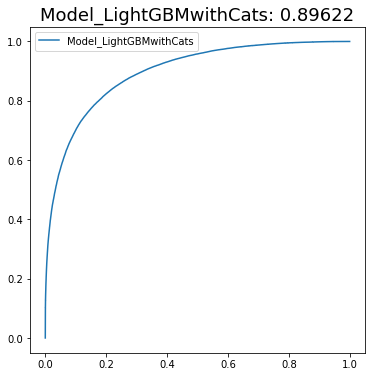

In [84]:
plot_results(model.__class__.__name__, target, oof_preds)

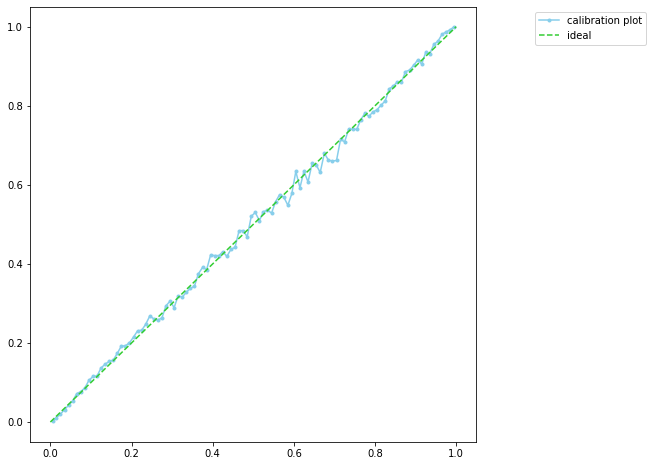

In [97]:
prob_true, prob_pred = calibration_curve(y_true=target, y_prob=oof_preds, n_bins=100)

fig, ax1 = plt.subplots(figsize=(8.0, 8.0))
ax1.plot(prob_pred, prob_true, marker='.', label='calibration plot', color='skyblue') # キャリプレーションプロットを作成
ax1.plot([0, 1], [0, 1], linestyle='--', label='ideal', color='limegreen') # 45度線をプロット
ax1.legend(bbox_to_anchor=(1.12, 1), loc='upper left')
plt.show()

In [84]:
submission['target'] = test_preds
submission.to_csv('submission.csv')

In [ ]:
with open("best_params.json", 'w') as f:
    json.dump(study.best_params, f, indent=4)

In [ ]:
LOG_PATH = '/content/drive/MyDrive/Kaggle/Tabular_Playground_Series_-_Mar_2021/Result/' + datetime.now(pytz.timezone('Asia/Tokyo')).strftime("%Y%m%d_%H:%M") + '_' + model.__class__.__name__ + '_NFOLDS:' + str(NFOLDS)
!mkdir $LOG_PATH
!cp /content/log.log $LOG_PATH
!cp /content/result.png $LOG_PATH
!cp /content/submission.csv $LOG_PATH
!cp /content/plot_optimization_history.html $LOG_PATH
!cp /content/plot_parallel_coordinate.html $LOG_PATH
!cp /content/plot_slice.html $LOG_PATH
!cp /content/plot_param_importances.html $LOG_PATH
!cp /content/plot_contour.html $LOG_PATH
!cp /content/best_params.json $LOG_PATH
#LOG_PATH = LOG_PATH.replace('\\','')

In [ ]:
#ensemble

#model = Model_LightGBM()
model = Model_LightGBMwithCats()
#model = Model_TabNet()

seeds_num = 30
#seeds = [21]
seeds = [i for i in range(seeds_num)]

test_preds = np.zeros(test.shape[0])
oof_preds = np.zeros((train.shape[0], seeds_num))
result = []

#----- Timer Set -----#
start_time = time.perf_counter()

for i in tqdm(range(len(seeds))):
    seed = seeds[i]
    #LightBGM_params['random_state'] = seed
    #model.reset_model(**LightBGM_params)
    LightBGMwithCats_params['random_state'] = seed
    model.reset_model(**LightBGMwithCats_params)
    #TabNet_params['seed'] = seed
    #model.reset_model(**TabNet_params)

    kf = KFold(n_splits=NFOLDS, shuffle=True, random_state=seed)
    #for tr_idx, va_idx in kf.split(train):
    for fold_, (tr_idx, va_idx) in enumerate(kf.split(train, target)):
        print("fold : ---------------------------------------", fold_)
        tr_x, va_x = train.iloc[tr_idx], train.iloc[va_idx]
        tr_y, va_y = target.iloc[tr_idx], target.iloc[va_idx]

        model.fit(tr_x, tr_y, va_x, va_y)
        oof_preds[va_idx,seed] = model.predict(va_x)
        test_preds += model.predict(test) / (NFOLDS * seeds_num)

    tmp_RMSE = mean_squared_error(target, oof_preds[:, seed], squared=False)
    print('RMSE[' + str(seed) + '] : ' + str(tmp_RMSE))
    logger.info(f'RMSE[{seed}] : {tmp_RMSE}')
    result.append([seed,tmp_RMSE])

#----- File Save -----#
np.savetxt('test_preds.csv', test_preds, delimiter=',')
np.savetxt('oof_preds.csv', oof_preds, delimiter=',')
np.savetxt('results.csv', result, delimiter=',')

#----- Timer Stop -----#
execution_time = time.perf_counter() - start_time
print("Learning time:{0}".format(execution_time/60) + "[min]")

#----- Log -----#
logger.info(f'Learning time : {execution_time/60}[min]')

**---------- Feature Search ----------**

In [ ]:
select_features = [
    "cat0", "cat1", "cat2", "cat3", "cat5", "cat6", "cat7", 
    "cat8", "cat9",
    "cont0", "cont1", "cont3", 
    "cont5", "cont6", "cont7", "cont8", "cont9", 
    "cont11", "cont13"
]

In [ ]:
features = [
    "cont10", "cont4", "cont12", "cont2",
    "cont8/cont5", "cont0/cont8", "cont5/cont12", "cont8/cont2", "cont6/cont0", "cont8/cont0"
]

In [ ]:
#----- Timer Set -----#
start_time = time.perf_counter()

model = Model_LightGBMwithCats()

results = []

#select_features = []

for i in tqdm(range(len(features))):
    oof_preds = np.zeros(train.shape[0])
    tmp_oof_preds = np.zeros(train.shape[0])

    min_RMSE = 100
    min_feature = ''

    for f in features:
        print("feature : ---------------------------------------", f)
        select_features.append(f)
        print(select_features)

        tmp_train = train[select_features]

        model.reset_model(**LightBGMwithCats_params)

        kf = KFold(n_splits=NFOLDS, shuffle=True, random_state=21)
    
        for fold_, (tr_idx, va_idx) in enumerate(kf.split(tmp_train, target)):
            print("fold : ---------------------------------------", fold_)
            tr_x, va_x = tmp_train.iloc[tr_idx], tmp_train.iloc[va_idx]
            tr_y, va_y = target.iloc[tr_idx], target.iloc[va_idx]

            model.fit(tr_x, tr_y, va_x, va_y)
            oof_preds[va_idx]= model.predict(va_x)

        tmp_RMSE = mean_squared_error(target, oof_preds, squared=False)
        print('RMSE : ' + str(tmp_RMSE))
        logger.info(f'RMSE : {tmp_RMSE}')
        if min_RMSE > tmp_RMSE:
            min_RMSE = tmp_RMSE
            min_feature = f
        select_features.remove(f)

    #print('min_RMSE : ',min_feature ,min_RMSE)
    #logger.info(f'RMSE : {min_feature, min_RMSE}')
    results.append([min_feature, min_RMSE])
    select_features.append(min_feature)
    features.remove(min_feature)

pd.DataFrame(results).to_csv('results.csv')

#----- Timer Stop -----#
execution_time = time.perf_counter() - start_time
print("Learning time:{0}".format(execution_time/60) + "[min]")

#----- Log -----#
logger.info(f'Learning time : {execution_time/60}[min]')

In [ ]:
results = np.array(results)

fig = plt.figure(figsize=(20, 8))
x_position = np.arange(len(results[:,0]))
ax = fig.add_subplot(1, 1, 1)
ax.bar(x_position, results[:,1], tick_label=results[:,0])
#ax.title('RMSE over select_features')
#ax.xlabel('Features')
#ax.ylabel('RMSE')
#plt.ylim(0.84, 0.86)
#ax.savefig("results.png")

In [ ]:
#LOG_PATH = '/content/drive/MyDrive/Kaggle/Tabular_Playground_Series_-_Feb_2021/Result/' + datetime.now(pytz.timezone('Asia/Tokyo')).strftime("%Y%m%d_%H:%M") + '_' + model.__class__.__name__
LOG_PATH = '/content/drive/MyDrive/Kaggle/Tabular_Playground_Series_-_Feb_2021/Result/' + datetime.now(pytz.timezone('Asia/Tokyo')).strftime("%Y%m%d_%H:%M") + '_EDA'
!mkdir $LOG_PATH
!cp /content/log_v1.log $LOG_PATH
!cp /content/results.csv $LOG_PATH
!cp /content/results.png $LOG_PATH

**---------- Feature Search2 ----------**

In [ ]:
train = pd.read_csv(input_path / 'train3.csv', index_col='id')
display(train.head())

In [ ]:
test = pd.read_csv(input_path / 'test3.csv', index_col='id')
display(test.head())

In [ ]:
target = pd.read_csv(input_path / 'target.csv', index_col='id')
display(target.head())

In [ ]:
print(train.shape)
print(test.shape)
print(target.shape)

In [ ]:
features = [
    "cat0", "cat1", "cat2", "cat3", "cat5", "cat6", "cat7", "cat8", "cat9",
    "cont0", "cont1", "cont2", "cont3", "cont4",
    "cont5", "cont6", "cont7", "cont8", "cont9", "cont10", 
    "cont11", "cont12", "cont13"
]

In [ ]:
#Candidate
print(train.columns.values.tolist())
print(len(train.columns.values.tolist()))
candidate = [c for c in train.columns.values.tolist() if c not in features]
candidate = np.array(candidate)[0:100].tolist()
#candidate = ['cat2_cont0_count', 'cat0_cont0_count']
print(candidate)
print(len(candidate))

In [ ]:
#----- Timer Set -----#
start_time = time.perf_counter()

model = Model_LightGBMwithCats()
oof_preds = np.zeros(train.shape[0])

results = []

tmp_train = train[features]
model.reset_model(**LightBGMwithCats_params)
kf = KFold(n_splits=NFOLDS, shuffle=True, random_state=21)
for fold_, (tr_idx, va_idx) in enumerate(kf.split(tmp_train, target)):
    print("fold : ---------------------------------------", fold_)
    tr_x, va_x = tmp_train.iloc[tr_idx], tmp_train.iloc[va_idx]
    tr_y, va_y = target.iloc[tr_idx], target.iloc[va_idx]

    model.fit(tr_x, tr_y, va_x, va_y)
    oof_preds[va_idx]= model.predict(va_x)

min_RMSE = mean_squared_error(target, oof_preds, squared=False)
print('original_RMSE : ' + str(min_RMSE))
logger.info(f'original_RMSE : {min_RMSE}')

results.append(['original', min_RMSE])

count = 0

for i in tqdm(range(1)):
    min_feature = ''

    for f in candidate:
        print("feature : ---------------------------------------", f)
        features.append(f)
        print(features)

        tmp_train = train[features]
        oof_preds = np.zeros(train.shape[0])

        model.reset_model(**LightBGMwithCats_params)

        kf = KFold(n_splits=NFOLDS, shuffle=True, random_state=21)
    
        for fold_, (tr_idx, va_idx) in enumerate(kf.split(tmp_train, target)):
            print("fold : ---------------------------------------", fold_)
            tr_x, va_x = tmp_train.iloc[tr_idx], tmp_train.iloc[va_idx]
            tr_y, va_y = target.iloc[tr_idx], target.iloc[va_idx]

            model.fit(tr_x, tr_y, va_x, va_y)
            oof_preds[va_idx]= model.predict(va_x)

        tmp_RMSE = mean_squared_error(target, oof_preds, squared=False)
        print(f + '_RMSE : ' + str(tmp_RMSE))
        logger.info(f'{f}_RMSE : {tmp_RMSE}')
        if min_RMSE > tmp_RMSE:
            min_RMSE = tmp_RMSE
            min_feature = f
            count += 1
        features.remove(f)

    #print('min_RMSE : ',min_feature ,min_RMSE)
    #logger.info(f'RMSE : {min_feature, min_RMSE}')
    if min_feature == '':
        print('No more efficent features.')
        break
    else:
        results.append([min_feature, min_RMSE])
        features.append(min_feature)
        candidate.remove(min_feature)

pd.DataFrame(results).to_csv('results.csv')

#----- Timer Stop -----#
execution_time = time.perf_counter() - start_time
print("Learning time:{0}".format(execution_time/60) + "[min]")
print("Count:{0}".format(count))

#----- Log -----#
logger.info(f'Learning time : {execution_time/60}[min]')
logger.info(f'Count : {count}')

In [ ]:
#LOG_PATH = '/content/drive/MyDrive/Kaggle/Tabular_Playground_Series_-_Feb_2021/Result/' + datetime.now(pytz.timezone('Asia/Tokyo')).strftime("%Y%m%d_%H:%M") + '_' + model.__class__.__name__
LOG_PATH = '/content/drive/MyDrive/Kaggle/Tabular_Playground_Series_-_Feb_2021/Result/' + datetime.now(pytz.timezone('Asia/Tokyo')).strftime("%Y%m%d_%H:%M") + '_EDA'
!mkdir $LOG_PATH
!cp /content/log_v1.log $LOG_PATH
!cp /content/results.csv $LOG_PATH

**---------- submission ----------**

In [ ]:
print(mean_squared_error(target, train['lightGBM_17'], squared=False))

In [ ]:
submission['target'] = test['lightGBM_17']
submission.to_csv('submission1.csv')

In [ ]:
submission

In [ ]:
tmp_train = pd.DataFrame(data=None, index=train.index, columns=None, dtype=None, copy=False)
tmp_test = pd.DataFrame(data=None, index=test.index, columns=None, dtype=None, copy=False)

In [ ]:
mean_train = pd.DataFrame(data=None, index=train.index, columns=None, dtype=None, copy=False)
mean_test = pd.DataFrame(data=None, index=test.index, columns=None, dtype=None, copy=False)

In [ ]:
res = []
for col in results.columns:
    tmp_train[col] = train[col]
    mean_train[col] = tmp_train.mean(axis=1)
    tmp_test[col] = test[col]
    mean_test[col] = tmp_test.mean(axis=1)
    RMSE = mean_squared_error(target, mean_train[col], squared=False)
    res.append([col,str(RMSE)])

In [ ]:
res

In [ ]:
pd.DataFrame(res).to_csv('res.csv')

In [ ]:
submission['target'] = mean_test['lightGBM_32']
submission.to_csv('submission2.csv')

In [ ]:
submission